In [1]:
import sys
sys.path.append('../src')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
NE = 600
Ds_pert = np.array([10, 50, 100, 200, 300, 400])
Ks_input = np.array([5, 10, 20, 40, 60, 100])
T_burn = 500

In [3]:
df_vpp = dict(tid=[], model=[], d=[], perturbed=[], unperturbed=[], 
              spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('../results/vary_percent_pert_%d.pkl' % i, 'rb') as f:
        # EIres, FFres, err, syl = pickle.load(f)
        EIzs, FFzs, EIsparsity, FFsparsity = pickle.load(f)
        df_vpp['tid'].extend([i] * len(Ds_pert) * 2)
        df_vpp['model'].extend(['EI network'] * len(Ds_pert) + ['Feedforward'] * len(Ds_pert))
        df_vpp['d'].extend(list(Ds_pert / NE * 100) * 2)
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], EIzs)))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], FFzs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], EIzs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], FFzs)))
        
        for th in EIsparsity.keys():
            df_vpp['spar%d'%th].extend(EIsparsity[th].mean(axis=1) * 100)
            df_vpp['spar%d'%th].extend(FFsparsity[th].mean(axis=1) * 100)

In [4]:
df_vpp = pd.DataFrame(df_vpp)
df_vpp_z = df_vpp[['tid', 'model', 'd', 'perturbed', 'unperturbed']].copy()
df_vpp_z = df_vpp_z.melt(id_vars=[_ for _ in df_vpp_z.columns if 'pert' not in _], 
                 value_vars=['perturbed', 'unperturbed'], 
                 var_name='subpopulation', value_name='z')

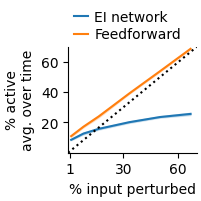

In [5]:
fig, ax = plt.subplots(1, figsize=(2, 2))
sns.lineplot(data=df_vpp, x='d', y='spar3', hue='model',legend='brief',  ax=ax)
ax.plot([0, 70], [0, 70], ls=':', c='k')
ax.set(ylabel='% active\navg. over time', xticks=[1, 30, 60], yticks=[20, 40, 60], 
       xlim=[0, 70], ylim=[0, 70])
ax.set_xlabel('% input perturbed')
ax.legend(loc=(0, 1))
fig.savefig('../svg/vary_pert_percent_active.svg')

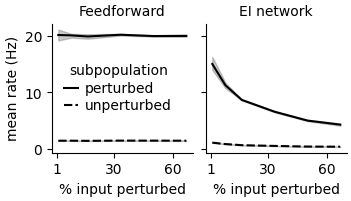

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(3.5, 2), sharey='all', sharex='all')
sns.lineplot(data=df_vpp_z[df_vpp_z.model=='Feedforward'], x='d', y='z', style='subpopulation', 
             color='k', ax=ax[0])
sns.lineplot(data=df_vpp_z[df_vpp_z.model=='EI network'], x='d', y='z', style='subpopulation', 
             legend=False, color='k', ax=ax[1])
ax[0].legend(loc='center left', title='subpopulation')
ax[0].set(xlabel='% input perturbed', ylabel='mean rate (Hz)', xticks=[1, 30, 60])
ax[1].set(xlabel='% input perturbed', xticks=[1, 30, 60])
ax[0].set_title('Feedforward', fontsize=10)
ax[1].set_title('EI network', fontsize=10)
fig.savefig('../svg/supplementary/vary_pert_quality.svg')

In [7]:
df_vid = dict(tid=[], model=[], d=[], mid_pwcorr=[], large_pwcorr=[], 
              spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('../results/vary_input_dim_%d.pkl' % i, 'rb') as f:
        EIpwcorrs, FFpwcorrs, EIsparsity, FFsparsity = pickle.load(f)
        df_vid['tid'].extend([i] * len(Ks_input) * 2)
        df_vid['model'].extend(['EI network'] * len(Ks_input) + ['Feedforward'] * len(Ks_input))
        df_vid['d'].extend(list(NE / Ks_input) * 2)
        f = lambda x: 100*(np.sum(x>0.8)-NE)/(NE**2-NE)
        df_vid['large_pwcorr'].extend(list(map(f, EIpwcorrs)))
        df_vid['large_pwcorr'].extend(list(map(f, FFpwcorrs)))
        f = lambda x: np.median(x[np.tril_indices(NE, k=-1)])
        df_vid['mid_pwcorr'].extend(list(map(f, EIpwcorrs)))
        df_vid['mid_pwcorr'].extend(list(map(f, FFpwcorrs)))
        
        for th in EIsparsity.keys():
            df_vid['spar%d'%th].extend(np.vstack(EIsparsity[th]).mean(axis=1) * 100)
            df_vid['spar%d'%th].extend(np.vstack(FFsparsity[th]).mean(axis=1) * 100)

In [8]:
df_vid = pd.DataFrame(df_vid)
df_vid['d_rel'] = df_vid['d'] / NE * 100

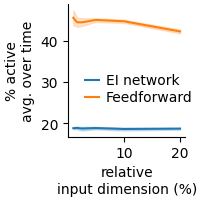

In [9]:
fig, ax = plt.subplots(1, figsize=(2, 2), sharex='all')
sns.lineplot(data=df_vid, x='d_rel', y='spar3', hue='model',legend='brief',  ax=ax)
ax.set(ylabel='% active\navg. over time', xlabel='relative\ninput dimension (%)')
ax.legend(loc=(0.1, 0.2))
fig.savefig('../svg/vary_input_dim_percent_active.svg')

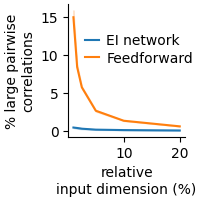

In [10]:
fig, ax = plt.subplots(1, figsize=(2, 2), sharex='all')
sns.lineplot(data=df_vid, x='d_rel', y='large_pwcorr', hue='model',legend='brief',  ax=ax)
ax.set(ylabel='% large pairwise\ncorrelations', xlabel='relative\ninput dimension (%)')
ax.legend(loc=(0.1, 0.5))
fig.savefig('../svg/vary_input_dim_percent_large_pwcorr.svg')

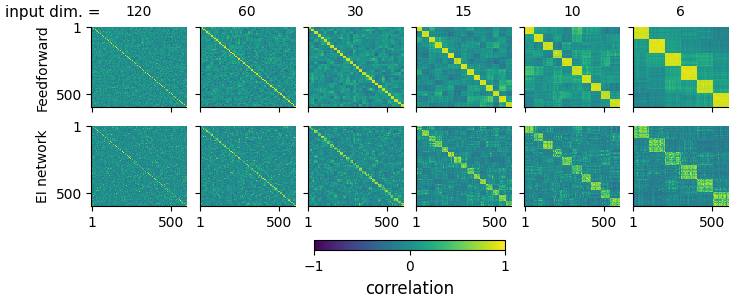

In [11]:
from sklearn.cluster import HDBSCAN
with open('../results/vary_input_dim_%d.pkl' % 1, 'rb') as f:
# with open('../results/vary_percent_pert_%d.pkl' % 1, 'rb') as f:
    EIpwcorrs, FFpwcorrs = pickle.load(f)[:2]
i_sel = list(range(len(EIpwcorrs)))
fig, ax = plt.subplots(2, len(i_sel), figsize=(7, 3), sharex='col', sharey='all')
for k, pwcorrs in enumerate((FFpwcorrs, EIpwcorrs)):
    ax[k,0].set_ylabel('Feedforward' if k == 0 else 'EI network', fontsize=10)
    for i, j in enumerate(i_sel):
        # hdb = HDBSCAN(metric='precomputed', min_cluster_size=5)
        # hdb.fit(1-pwcorrs[j])
        # idx = np.argsort(hdb.labels_)[::-1] # [::-1] puts -1 in the end
        # im = ax[k,i].imshow(pwcorrs[j][idx,:][:,idx], vmin=-1, vmax=1, interpolation='none')
        im = ax[k,i].imshow(pwcorrs[j], vmin=-1, vmax=1, interpolation='none')
        ax[0,i].set_title('%d' % (NE / Ks_input[j]), fontsize=10, va='bottom')
        ax[1,i].set(xticks=[1, 500], yticks=[1, 500])
fig.text(0.03, 0.985, 'input dim. =', ha='center', va='top', fontsize=11)
cax = fig.colorbar(im, ax=ax, shrink=0.3, pad=0.05, ticks=[-1, 0, 1], 
                   orientation='horizontal')
cax.set_label('correlation', fontsize=12)
fig.savefig('../svg/supplementary/vary_input_dim_corrmat.svg', bbox_inches='tight')

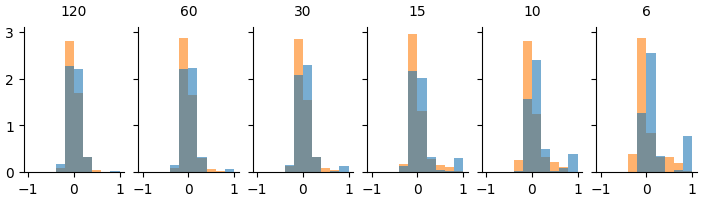

In [12]:
i_sel = list(range(len(EIpwcorrs)))
fig, ax = plt.subplots(1, len(i_sel), figsize=(7, 2), sharey='all')
for i, j in enumerate(i_sel):
    ax[i].hist([FFpwcorrs[j][np.tril_indices(NE, k=-1)], 
                EIpwcorrs[j][np.tril_indices(NE, k=-1)]], 
               label=['Feedforward', 'EI network'],
               range=(-1, 1), bins=10, density=True, histtype='stepfilled', alpha=0.6)
    ax[i].set_title('%d' % (NE / Ks_input[j]), fontsize=10, va='bottom')